In [1]:
%matplotlib inline

from bed_reader import open_bed
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import pandas as pd
from scipy.stats import pearsonr
import time
import matplotlib.pyplot as plt

# Data preprocessing

In [2]:
with open_bed("../Data/BBBDL_BBB2023_MD.bed") as bed:
    data = bed.read(index=np.s_[:3000,:], dtype="int8")

# Check that data is free of missing values
classes, counts = np.unique(data, return_counts=True)
if classes.all() != np.array([0, 1, 2]).all():
    raise Exception(f"There are {counts[np.where(classes == -127)[0][0]]} missing values in the data!")

train_data = data[:2000]
val_data = data[2000:]

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (2000, 36304)
Validation data shape: (1000, 36304)


# Phenotype processing

In [3]:
pheno_df = pd.read_csv("../Data/BBBDL_pheno_20000bbb_6traits_processed.csv", index_col=1)
Y_train = pheno_df[:2000]["pheno_1"].tolist()
Y_val = pheno_df[2000:3000]["pheno_1"].tolist()
print(f"Dataframe sample: \n{pheno_df[:10]}\n")

print(f"Y_train length: {len(Y_train)}")
print(f"Y_val length: {len(Y_val)}")

Dataframe sample: 
            idk   pheno_1   pheno_2   pheno_3   pheno_4    pheno_5   pheno_6
id                                                                          
BBB2024_1     0  2.340485  1.048687  4.869720  3.754475  -3.981241  2.994999
BBB2024_2     0 -0.029124  4.097066  1.512663  0.915872   2.016372  0.839418
BBB2024_3     0  3.009160  1.033428  3.086161  2.775228  -0.972438  2.907029
BBB2024_4     0  3.133567  7.720563  4.487325  4.062251  -6.720532  4.485313
BBB2024_5     0  3.449609  4.448934  5.071065  4.734881  -8.064629  4.468693
BBB2024_6     0  0.394976 -4.779438  0.166496  0.263310  -1.392216 -0.374317
BBB2024_7     0  2.906651 -1.434209  1.090841  3.148582 -13.145888  0.840723
BBB2024_8     0  1.517752  0.903852 -0.878456 -0.016035 -13.562437  0.074280
BBB2024_9     0 -0.086624 -0.349057  1.429496  0.997888   2.749404  0.299504
BBB2024_10    0  2.075847  3.703129  2.241961  1.641621   2.203721  1.651413

Y_train length: 2000
Y_val length: 1000


# Model hyperparameter choice

In [4]:
max_depth = []
correlation = []
train_loss = []
val_loss = []
start_time = time.time()
print("--------------------------")
for i in range(5,41):
    model = RandomForestRegressor(max_depth=i, random_state=2307, n_jobs=-1).fit(train_data, Y_train)
    predictions = model.predict(val_data)
    max_depth.append(i)
    correlation.append(pearsonr(predictions, Y_val).statistic)
    train_loss.append(mean_squared_error(model.predict(train_data), Y_train))
    val_loss.append(mean_squared_error(model.predict(val_data), Y_val))
    print(f"Max depth value tested: {i}")
    print(f"Elapsed time from start: {int((time.time() - start_time) // 60)}m {int((time.time() - start_time) % 60)}s")
    print(f"Pearson correlation: {correlation[-1]}")
    print("--------------------------")

# Display results if required for futures comparaisons
print(f"Max_depth: {max_depth}")
print(f"Pearson correlation: {correlation}")
print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

--------------------------
Max depth value tested: 5
Elapsed time from start: 1m 37s
Pearson correlation: 0.34534940066285474
--------------------------
Max depth value tested: 6
Elapsed time from start: 3m 43s
Pearson correlation: 0.35507641400323836
--------------------------
Max depth value tested: 7
Elapsed time from start: 6m 22s
Pearson correlation: 0.34538291099976703
--------------------------
Max depth value tested: 8
Elapsed time from start: 9m 40s
Pearson correlation: 0.3442907200156523
--------------------------
Max depth value tested: 9
Elapsed time from start: 13m 40s
Pearson correlation: 0.34591513736117147
--------------------------
Max depth value tested: 10
Elapsed time from start: 18m 29s
Pearson correlation: 0.3596159301493123
--------------------------
Max depth value tested: 11
Elapsed time from start: 24m 7s
Pearson correlation: 0.3500388359168404
--------------------------
Max depth value tested: 12
Elapsed time from start: 30m 39s
Pearson correlation: 0.3451889

# Result display

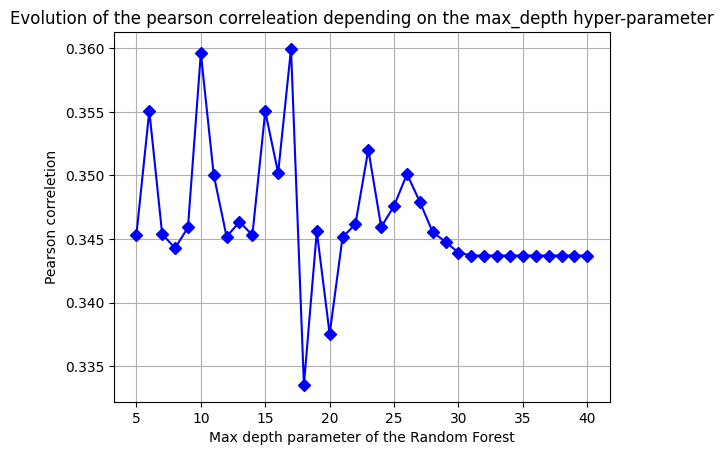

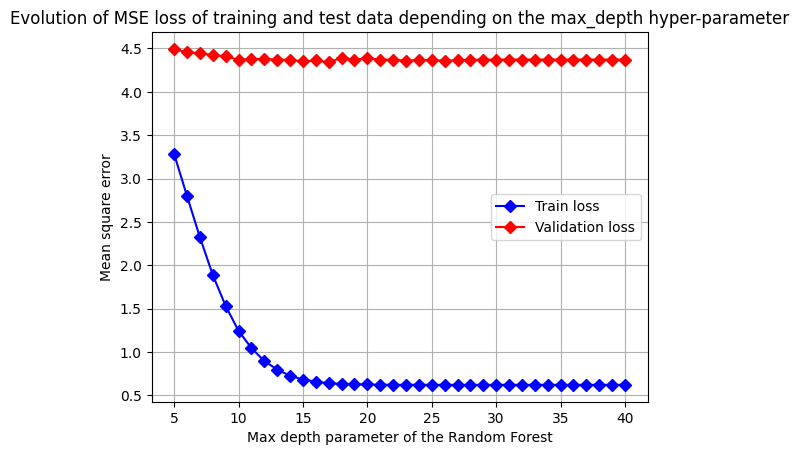

In [5]:
plt.plot(max_depth, correlation,color='blue', marker="D")
plt.grid()
plt.title("Evolution of the pearson correleation depending on the max_depth hyper-parameter")
plt.xlabel("Max depth parameter of the Random Forest")
plt.ylabel("Pearson correletion")
plt.show()
plt.close()

plt.plot(max_depth, train_loss, label="Train loss", color='blue', marker="D")
plt.plot(max_depth, val_loss, label="Validation loss", color='red', marker="D")
plt.legend()
plt.grid()
plt.title("Evolution of MSE loss of training and test data depending on the max_depth hyper-parameter")
plt.xlabel("Max depth parameter of the Random Forest")
plt.ylabel("Mean square error")
plt.show()
plt.close()